In [1]:
#import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from matplotlib.pyplot import figure
import time


#define plotting style that I like
style.use('fivethirtyeight')

#define constants
m_p=938.27231 #MeV
m_n=939.56563 #MeV
hbar_c=197.327053 #MeVfm

#define runtime calculator
def timer(elapsed_time):
    seconds = (time.time() - elapsed_time)
    day = seconds // (24 * 3600)
    seconds = seconds % (24 * 3600)
    hour = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60
    seconds = seconds
    print('')
    print('Total cell runtime:', "%s days, %s hours, %s minutes, %s seconds" % (day, hour, minutes, seconds) )
    print('')
    
# fucntions for k for each rxn type
def k_pp(energy):
    value=np.sqrt(((m_p**2)*(energy)*(energy+2*m_n))/(((m_p+m_n)**2)+(2*energy*m_p))) 
    k_pp=value/hbar_c 
    return k_pp
def k_np(energy):
    value=np.sqrt((1/2)*m_p*energy) 
    k_np=value/hbar_c 
    return k_np

# add k*experimental_value column
def change_np(rxn_observable):
    rxn_observable['K_experimental_value'] = rxn_observable.apply(lambda row: (row.experimental_value * k_np(row.energy)),axis=1)
    rxn_observable['K_sigma'] = rxn_observable.apply(lambda row: (row.sigma * k_np(row.energy)),axis=1)
def change_pp(rxn_observable):
    rxn_observable['K_experimental_value'] = rxn_observable.apply(lambda row: (row.experimental_value * k_pp(row.energy)),axis=1)
    rxn_observable['K_sigma'] = rxn_observable.apply(lambda row: (row.sigma * k_np(row.energy)),axis=1)

def split_and_score(size, number_of_random_states):
    test=np.zeros(number_of_random_states)
    train=np.zeros(number_of_random_states)
    for j in range(number_of_random_states):
        #split
        train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=size)
        #rf.train
        rf = RandomForestRegressor(n_estimators=1000)
        rf.fit(train_features, train_labels);
        predictions = rf.predict(test_features)
        rf_new = RandomForestRegressor(n_estimators = 100, criterion = 'mse', max_depth = None, min_samples_split = 2, min_samples_leaf = 1)
        importances = list(rf.feature_importances_)
        feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
        feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
        #score
        test[j]=rf.score(test_features,test_labels)
        train[j]=rf.score(train_features,train_labels)
    test_ave=np.mean(test)
    train_ave=np.mean(train)
    test_var=np.sqrt(np.var(test))
    train_var=np.sqrt(np.var(train))
    return test_ave, test_var, train_ave, train_var

def train_and_plot(rxn_observable, reac_observ):
    #start timer
    rxn_observable_time = time.time()
    # One-hot encode categorical features
    rxn_observable_plot = pd.get_dummies(rxn_observable)
    # Labels are the values we want to predict
    labels = np.array(rxn_observable_plot['K_experimental_value'])
    # Remove the labels from the features
    # axis 1 refers to the columns
    features = rxn_observable_plot.drop('K_experimental_value', axis = 1)
    # Saving feature names for later use
    feature_list = list(features.columns)
    # Convert to numpy array
    features = np.array(features)

    rxn_observable_test_mean=np.zeros(intervals) 
    rxn_observable_train_mean=np.zeros(intervals) 
    rxn_observable_test_variance=np.zeros(intervals) 
    rxn_observable_train_variance=np.zeros(intervals) 
    for i in range(intervals): 
        #define size
        size=(i+1)/(intervals+1)
        #call split function
        test, test_v, train, train_v = split_and_score(size, number_of_random_states)
        #add to arrays
        rxn_observable_test_mean[i]=test
        rxn_observable_train_mean[i]=train
        rxn_observable_test_variance[i]=test_v
        rxn_observable_train_variance[i]=train_v
    print("Average Testing Score:", rxn_observable_test_mean)
    print('Testing Variance', rxn_observable_test_variance)
    print('')
    print('Average Training Score', rxn_observable_train_mean)
    print('Training Variance', rxn_observable_train_variance)
    print('')

    #plot 

    #figure
    figure(figsize=(15, 5))
    ax=plt.subplot(111)
    plt.xlabel('Test Size (%)')
    plt.ylabel('Score')
    plt.title("Reaction_Observable: {}".format(reac_observ))
    plt.xlim(left=0, right=100)
    ax.scatter(sample_size, rxn_observable_test_mean, s=100, label='Average Testing Score')
    ax.scatter(sample_size, rxn_observable_train_mean, s=100, label='Average Training Score')
    ax.errorbar(sample_size, rxn_observable_test_mean, yerr=rxn_observable_test_variance, linestyle='none', capsize=10, elinewidth=2)
    ax.errorbar(sample_size, rxn_observable_train_mean, yerr=rxn_observable_train_variance, linestyle='none', capsize=10, elinewidth=2)
    ax.legend(loc='best')
    plt.show

    #print elapsed time
    timer(rxn_observable_time)

### Original Method

In [2]:
#organize experimental and phenomenological data for plotting
#read files
np_sgt=pd.read_csv('CSV_files/np.sgt.csv')
np_sgtt=pd.read_csv('CSV_files/np.sgtt.csv')
random_sgt=pd.read_csv('CSV_files/random.sgt.csv')
random_sgtt=pd.read_csv('CSV_files/random.sgtt.csv')
#add k*exp columns
random_sgt.rename(columns={' energy':'energy'}, inplace=True)
random_sgtt.rename(columns={' energy':'energy'}, inplace=True)
np_sgt.rename(columns={"statistical_error": "sigma"}, inplace=True)
np_sgtt.rename(columns={"statistical_error": "sigma"}, inplace=True)
change_np(np_sgt)
change_np(np_sgtt)
change_np(random_sgt)
change_np(random_sgtt)
#error bar arrays
rand_err_sgt=random_sgt['K_sigma'].tolist()
rand_err_sgtt=random_sgtt['K_sigma'].tolist()
exp_err_sgt=np_sgt['K_sigma'].tolist()
exp_err_sgtt=np_sgtt['K_sigma'].tolist()

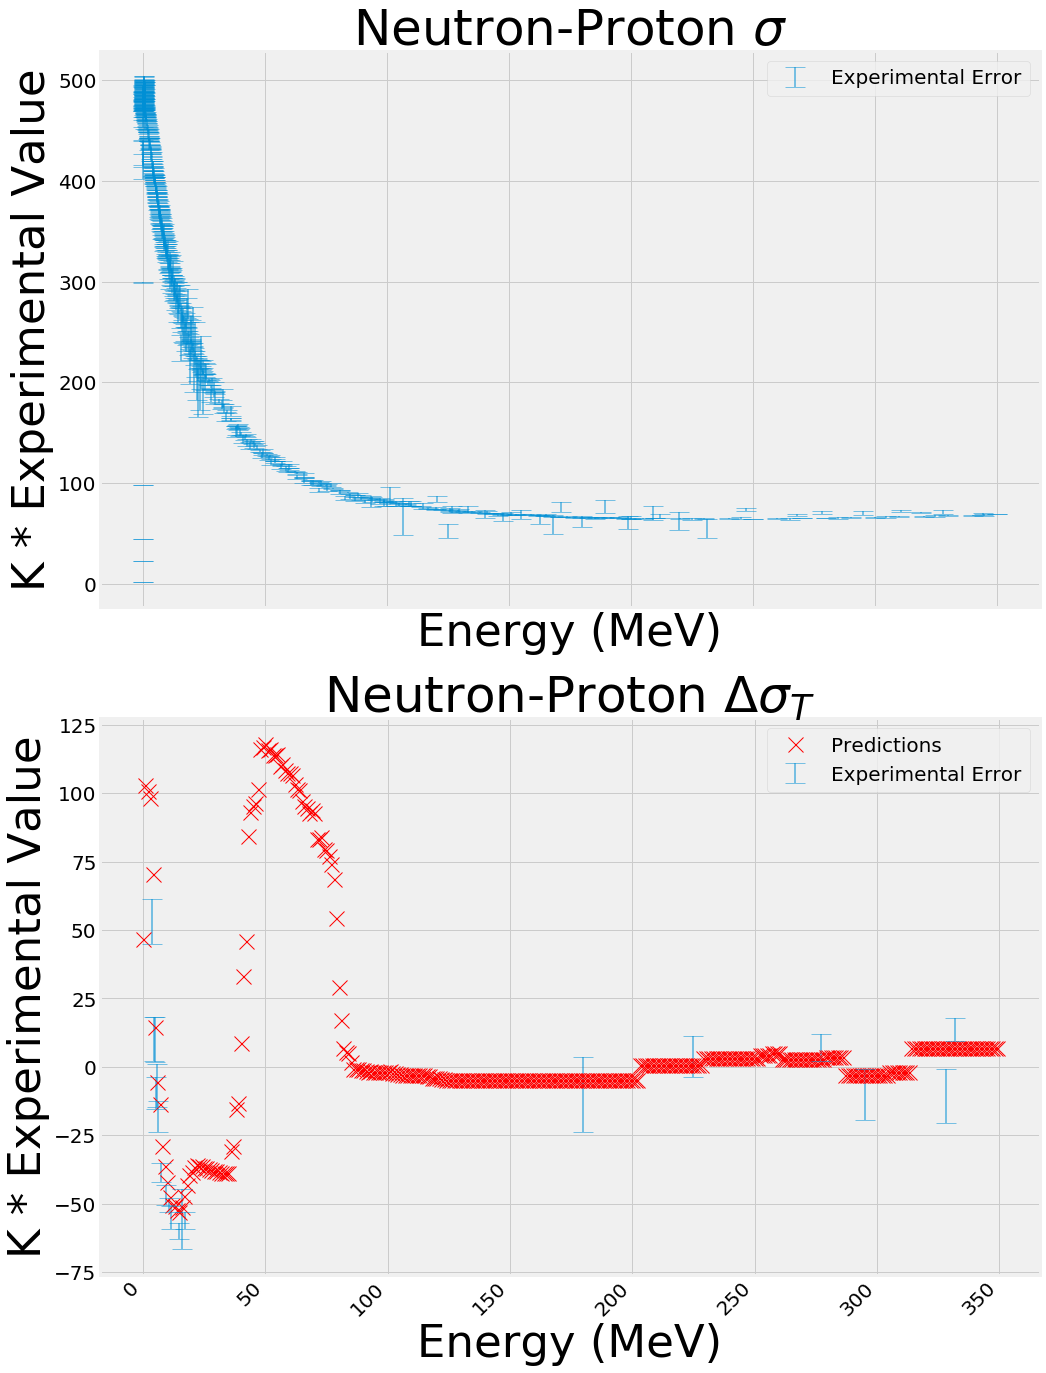

In [3]:
#read data file
data = pd.read_csv('CSV_files/np.sgt_and_sgtt.csv')
data.rename(columns={"statistical_error": "sigma"}, inplace=True)
#add k*exp column
change_np(data)
#remove columns that are not needed
data = data.drop(columns=['scattering_angle', 'K_sigma', 'sigma', 'systematic_error', 'normalization', 'experimental_value', 'reaction_type'])

#One-hot encode
features = pd.get_dummies(data)
# Labels are the values we want to predict
labels = np.array(features['K_experimental_value'])
# Remove the labels from the features
features = features.drop('K_experimental_value', axis = 1)
# Saving feature names for later use
feature_list = list(features.columns)
# Convert to numpy array
features = np.array(features)

train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25)

rf = RandomForestRegressor(n_estimators= 1000)
# Train the model on training data
rf.fit(train_features, train_labels);

#make predictions 
#construct testing arrays
interval_size = 1
num_intervals = 350/interval_size
E_SGT = []
E_SGTT = []
E = list(range(0, 350 + int(interval_size/2), interval_size))
for value in range(0, 350 + int(interval_size/2), interval_size):
    E_SGT.append([value, 1, 0])
    E_SGTT.append([value, 0, 1])
#predict
#SGT
SGT_predictions = rf.predict(E_SGT)
#SGTT
SGTT_predictions = rf.predict(E_SGTT)

#generate arrays for plotting
np_sgt=pd.read_csv('CSV_files/np.sgt.csv')
np_sgt.rename(columns={"statistical_error": "sigma"}, inplace=True)
np_sgtt=pd.read_csv('CSV_files/np.sgtt.csv')
np_sgtt.rename(columns={"statistical_error": "sigma"}, inplace=True)
change_np(np_sgt)
change_np(np_sgtt)


#plot
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize = (15,25))
fig.autofmt_xdate(rotation = 45)
#plot 1
#ax1.plot(E, SGT_predictions, 'rx', markersize=15,  alpha=1.0, label='Predictions')
#ax1.plot(np_sgt['energy'], np_sgt['K_experimental_value'], 'bo', alpha=0.3, label='Raw Experimental Data')
ax1.errorbar(np_sgt['energy'], np_sgt['K_experimental_value'], yerr=exp_err_sgt, linestyle='none', capsize=10, elinewidth=2, alpha=0.5, label='Experimental Error')

ax1.tick_params(axis="y", labelsize=20); ax1.tick_params(axis="x", labelsize=20)
ax1.legend(loc='best', fontsize=20)
ax1.set_xlabel('Energy (MeV)', fontsize=45); ax1.set_ylabel('K * Experimental Value', fontsize=45); ax1.set_title('Neutron-Proton $\sigma$', fontsize=50)
#plot 2
ax2.plot(E, SGTT_predictions, 'rx', markersize=15, alpha=1.0, label='Predictions')
#ax2.plot(np_sgtt['energy'], np_sgtt['K_experimental_value'], 'bo', alpha=0.3, label='Raw Experimental Data')
ax2.errorbar(np_sgtt['energy'], np_sgtt['K_experimental_value'], yerr=exp_err_sgtt, linestyle='none', capsize=10, elinewidth=2, alpha=0.5, label='Experimental Error')

ax2.tick_params(axis="y", labelsize=20); ax2.tick_params(axis="x", labelsize=20)
ax2.legend(loc='best', fontsize=20)
ax2.set_xlabel('Energy (MeV)', fontsize=45); ax2.set_ylabel('K * Experimental Value', fontsize=45); ax2.set_title('Neutron-Proton $\Delta \sigma_T$', fontsize=50)
#save figures
plt.savefig('Plots/predictions_no_phenom.pdf', format='pdf', bbox_inches='tight', transparent=True)

In [4]:
data.head(6)

,energy,observable,K_experimental_value
0,0.000001,SGT,2.243152
1,0.000100,SGT,22.491891
2,0.000400,SGT,44.863041
3,0.001970,SGT,98.070798
4,0.023645,SGT,299.288620
5,0.060000,SGT,414.056082


### Gaussian Factor

In [5]:
#organize experimental and phenomenological data for plotting
#read files
np_sgt=pd.read_csv('CSV_files/np.sgt.csv')
np_sgtt=pd.read_csv('CSV_files/np.sgtt.csv')
random_sgt=pd.read_csv('CSV_files/random.sgt.csv')
random_sgtt=pd.read_csv('CSV_files/random.sgtt.csv')
#add k*exp columns
random_sgt.rename(columns={' energy':'energy'}, inplace=True)
random_sgtt.rename(columns={' energy':'energy'}, inplace=True)
np_sgt.rename(columns={"statistical_error": "sigma"}, inplace=True)
np_sgtt.rename(columns={"statistical_error": "sigma"}, inplace=True)
change_np(np_sgt)
change_np(np_sgtt)
change_np(random_sgt)
change_np(random_sgtt)
#error bar arrays
rand_err_sgt=random_sgt['K_sigma'].tolist()
rand_err_sgtt=random_sgtt['K_sigma'].tolist()
exp_err_sgt=np_sgt['K_sigma'].tolist()
exp_err_sgtt=np_sgtt['K_sigma'].tolist()

In [6]:
def combine_data():
    ###create combined dataframe
    #random data
    random_data = pd.read_csv('CSV_files/random.sgt_and_sgtt.csv')
    random_data = random_data.drop(columns=["reaction_type"])
    random_data.rename(columns={' energy':'energy'}, inplace=True)
    random_data = random_data.drop(columns=['k'])
    #experimental data
    exp_data = pd.read_csv('CSV_files/np.sgt_and_sgtt.csv')
    exp_data = exp_data.drop(columns=['scattering_angle', 'normalization', 'reaction_type', 'systematic_error'])
    exp_data.rename(columns={"statistical_error": "sigma"}, inplace=True)
    #combine
    combined_data = pd.concat([random_data, exp_data], sort=True)
    #combined_data = pd.concat([random_data], sort=True)
    combined_data['k'] = combined_data.apply(lambda row: k_np(row.energy), axis=1)
    change_np(combined_data)
    return combined_data

def gauss_factor(combined_data, mu, sigma):
    ###create Gaussian factor 
    #Gaussian distribution
    combined_data['Gauss_factor'] = np.random.normal(mu, sigma, len(combined_data.energy))
    combined_data['Gauss_exp'] = combined_data.apply(lambda row: ((row.K_experimental_value) + (row.K_sigma*row.Gauss_factor)), axis=1)
    #remove unecessary columns
    combined_data = combined_data.drop(columns=['K_experimental_value', 'K_sigma', 'experimental_value', 'k', 'sigma', 'Gauss_factor'])
    return combined_data

In [7]:
################################ ATTEMPT 2 ##################################
#make dataframe
#index will be value of energy (use df.set_index(E))
#dynamically create new column for each set of predictions
#create separate lists for the average and variance of each row 
#maybe that will work? 


In [8]:
combined_data=combine_data()
combined_data=gauss_factor(combined_data,0,1)
combined_data.head(4)

,energy,observable,Gauss_exp
0,238.226430,SGT,65.292896
1,35.918331,SGT,164.377741
2,181.784790,SGT,66.495352
3,264.710330,SGT,65.698070


In [14]:
#######################################################
#######################################################
#######################################################
#######################################################
#######################################################
#######################################################
#######################################################
#######################################################
###  PARAMETERS TO BE CHANGED ARE ALL IN THIS CELL  ###
#######################################################
#######################################################
#######################################################
#######################################################
#######################################################
#######################################################
#######################################################
#######################################################

#define number of times to make predictions with different gaussian factor
n_max=5

#define interval step size for predictions 
###MUST BE INTEGER >=1 AND FACTOR OF 350
interval_size = 10 #MeV  

#define number of trees used in random forest 
num_trees=1000

#define test size
test_data_size = 0.25 # % of total amount of data

Predictions computed with n = 1 
Predictions computed with n = 2 
Predictions computed with n = 3 
Predictions computed with n = 4 
Predictions computed with n = 5 

Total cell runtime: 0.0 days, 0.0 hours, 0.0 minutes, 8.831023931503296 seconds



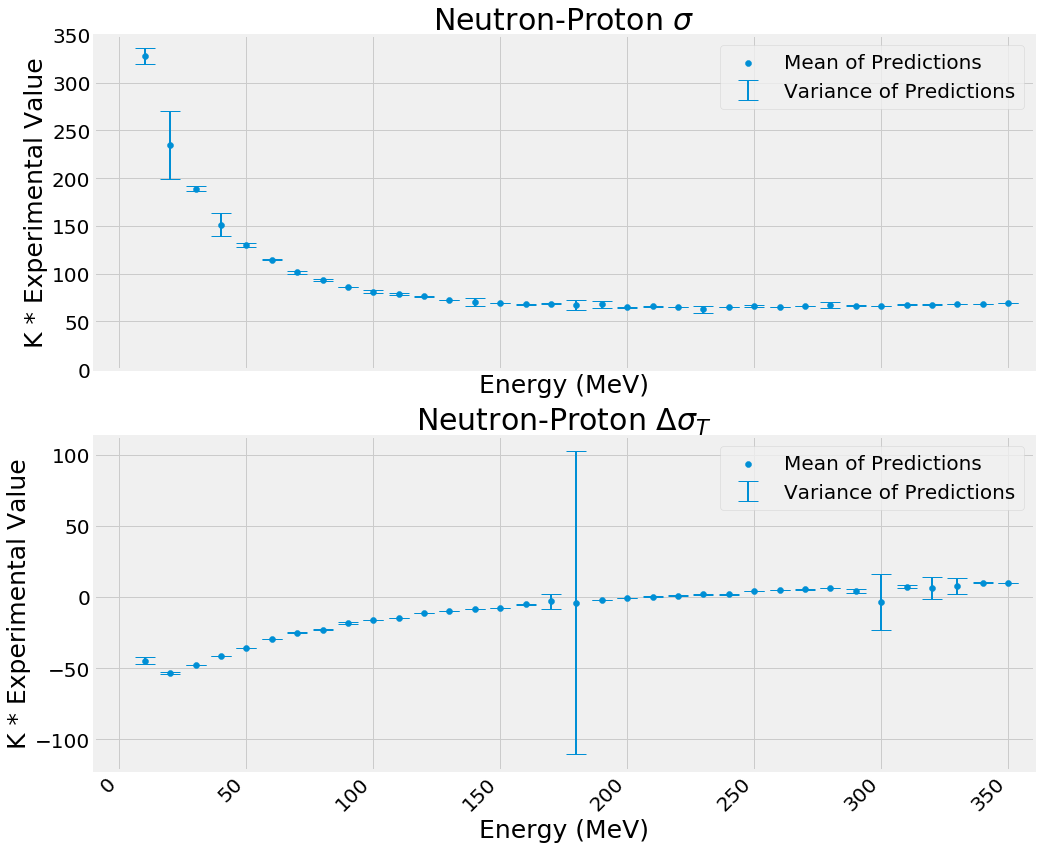

In [18]:
#start timer
gauss_time=time.time()

#define interval specifications for prediction arrays
E_max=350
num_intervals = E_max/interval_size
E_index = list(range(interval_size, E_max + int(interval_size), interval_size)) ###this will be index of dataframe

df_SGT=pd.DataFrame({'Energy': E_index})
df_SGTT=pd.DataFrame({'Energy': E_index})


for n in range(1,n_max+1):
    ###create combined dataframe
    combined_data=combine_data()
    ###create Gaussian factor 
    combined_data=gauss_factor(combined_data, 0, 1)

    ###train
    #One-hot encode
    features = pd.get_dummies(combined_data)
    # Labels are the values we want to predict
    labels = np.array(features['Gauss_exp'])
    # Remove the labels from the features
    features = features.drop('Gauss_exp', axis = 1)
    # Saving feature names for later use
    feature_list = list(features.columns)
    # Convert to numpy array
    features = np.array(features)
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = test_data_size)
    rf = RandomForestRegressor(n_estimators= num_trees)
    # Train the model on training data
    rf.fit(train_features, train_labels);

    ###make predictions 
    #construct testing arrays
    E_SGT = []
    E_SGTT = []
    E = list(range(interval_size, E_max + int(interval_size), interval_size))
    for value in E:
        E_SGT.append([value, 1, 0])
        E_SGTT.append([value, 0, 1])
    #predict
    #SGT
    SGT_predictions = rf.predict(E_SGT)
    #SGTT
    SGTT_predictions = rf.predict(E_SGTT)
    
    #add column to dataframes
    df_SGT["SGT_Preds_%s"%('%.0f'%n)] = SGT_predictions
    df_SGTT["SGTT_Preds_%s"%('%.0f'%n)] = SGTT_predictions
    
    #print completed message
    print("Predictions computed with n = %s "%('%.0f'%n))

#predictions array     
df_SGT = df_SGT.drop("Energy", axis=1)
df_SGT['Prediction Mean'] = df_SGT.mean(axis=1)
df_SGT['Prediction Variance'] = df_SGT.var(axis=1)
df_SGTT = df_SGTT.drop("Energy", axis=1)
df_SGTT['Prediction Mean'] = df_SGTT.mean(axis=1)
df_SGTT['Prediction Variance'] = df_SGTT.var(axis=1)

df_SGT.head(4)

#plot 
#figure specs
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize = (15,15))
fig.autofmt_xdate(rotation = 45)

#plot 1 - SGT
ax1.scatter(E, df_SGT['Prediction Mean'], label='Mean of Predictions')
ax1.errorbar(E, df_SGT['Prediction Mean'], yerr=df_SGT['Prediction Variance'], linestyle='none', capsize=10, elinewidth=2, label='Variance of Predictions')
#ax1.plot(np_sgt['energy'], np_sgt['K_experimental_value'], 'bo', alpha=0.3, label='Raw Experimental Data')
#ax1.plot(random_sgt['energy'], random_sgt['K_experimental_value'], 'k+', markersize=15, label='Phenomenological Data')
#ax1.errorbar(np_sgt['energy'], np_sgt['K_experimental_value'], yerr=exp_err_sgt, linestyle='none', capsize=10, elinewidth=2, alpha=0.5, label='Experimental Error')
#ax1.errorbar(random_sgt['energy'], random_sgt['K_experimental_value'], yerr=rand_err_sgt, linestyle='none', capsize=10, elinewidth=2, alpha=0.5, label='Phenomenological Error')

ax1.tick_params(axis="y", labelsize=20)
ax1.tick_params(axis="x", labelsize=20)
ax1.legend(loc='best', fontsize=20)
ax1.set_xlabel('Energy (MeV)', fontsize=25)
ax1.set_xlim([-10,360])
ax1.set_ylim(bottom=0)
ax1.set_ylabel('K * Experimental Value', fontsize=25)
ax1.set_title('Neutron-Proton $\sigma$', fontsize=30)

#plot 2 - SGTT
ax2.scatter(E, df_SGTT['Prediction Mean'], label='Mean of Predictions')
ax2.errorbar(E, df_SGTT['Prediction Mean'], yerr=df_SGTT['Prediction Variance'], linestyle='none', capsize=10, elinewidth=2, label='Variance of Predictions')
#ax2.plot(np_sgtt['energy'], np_sgtt['K_experimental_value'], 'bo', alpha=0.3, label='Raw Experimental Data')
#ax2.plot(random_sgtt['energy'], random_sgtt['K_experimental_value'], 'k+', markersize=15, label='Phenomenological Data')
#ax2.errorbar(np_sgtt['energy'], np_sgtt['K_experimental_value'], yerr=exp_err_sgtt, linestyle='none', capsize=10, elinewidth=2, alpha=0.5, label='Experimental Error')
#ax2.errorbar(random_sgtt['energy'], random_sgtt['K_experimental_value'], yerr=rand_err_sgtt, linestyle='none', capsize=10, elinewidth=2, alpha=0.5, label='Phenomenological Error')

ax2.tick_params(axis="y", labelsize=20)
ax2.tick_params(axis="x", labelsize=20)
ax2.legend(loc='best', fontsize=20)
ax2.set_xlabel('Energy (MeV)', fontsize=25)
ax2.set_xlim([-10,360])
ax2.set_ylabel('K * Experimental Value', fontsize=25)
ax2.set_title('Neutron-Proton $\Delta \sigma_T$', fontsize=30)

#save figures
plt.savefig('Plots/predictions_with_gauss.pdf', format='pdf', bboxinches='tight', transparent=True)

#print elapsed time
timer(gauss_time)

In [19]:
df_SGT['Energy']=E
df_SGT.set_index("Energy", inplace = True)
df_SGT

,SGT_Preds_1,SGT_Preds_2,SGT_Preds_3,SGT_Preds_4,SGT_Preds_5,Prediction Mean,Prediction Variance
Energy,,,,,,,
10,329.033320,330.177509,329.618342,322.397052,327.818088,327.808862,7.934354
20,226.985083,230.306276,232.324701,243.195999,239.438318,234.450075,35.757630
30,190.880652,190.721753,188.237483,188.497128,186.930331,189.053469,2.320966
40,149.587171,152.571492,151.339556,156.523358,145.914804,151.187276,12.154465
50,130.087690,128.744182,128.771910,131.118659,132.651766,130.274841,2.199709
60,114.678421,114.114790,113.260913,115.650165,114.270166,114.394891,0.607204
70,98.970547,100.380159,102.835048,101.181361,102.338748,101.141173,1.919154
80,93.191355,92.985493,93.982124,93.585022,91.152391,92.979277,0.951032
90,85.272405,85.878009,86.701989,85.681838,85.430499,85.792948,0.249654


In [20]:
df_SGTT['Energy']=E
df_SGTT.set_index("Energy", inplace = True)
df_SGTT

,SGTT_Preds_1,SGTT_Preds_2,SGTT_Preds_3,SGTT_Preds_4,SGTT_Preds_5,Prediction Mean,Prediction Variance
Energy,,,,,,,
10,-42.278089,-44.532719,-46.435954,-46.597292,-44.782819,-44.925375,2.451956
20,-53.034747,-53.960251,-52.640578,-52.969989,-54.533699,-53.427853,0.498063
30,-47.961857,-48.134410,-46.936316,-47.853066,-48.131124,-47.803355,0.199276
40,-41.444106,-41.721183,-40.851122,-41.993603,-41.197557,-41.441514,0.158220
50,-34.922792,-35.455771,-36.134544,-36.230238,-36.378850,-35.824439,0.303419
60,-29.530731,-29.838374,-29.554335,-29.618575,-29.714681,-29.651339,0.012805
70,-24.952349,-25.030256,-26.164947,-25.054567,-24.750331,-25.190490,0.248833
80,-23.003465,-23.287391,-22.918983,-23.433101,-21.731858,-22.874960,0.361351
90,-18.961167,-17.896062,-18.185677,-16.784707,-18.670860,-18.099694,0.569283


#### Gaussian Done 1 Time 

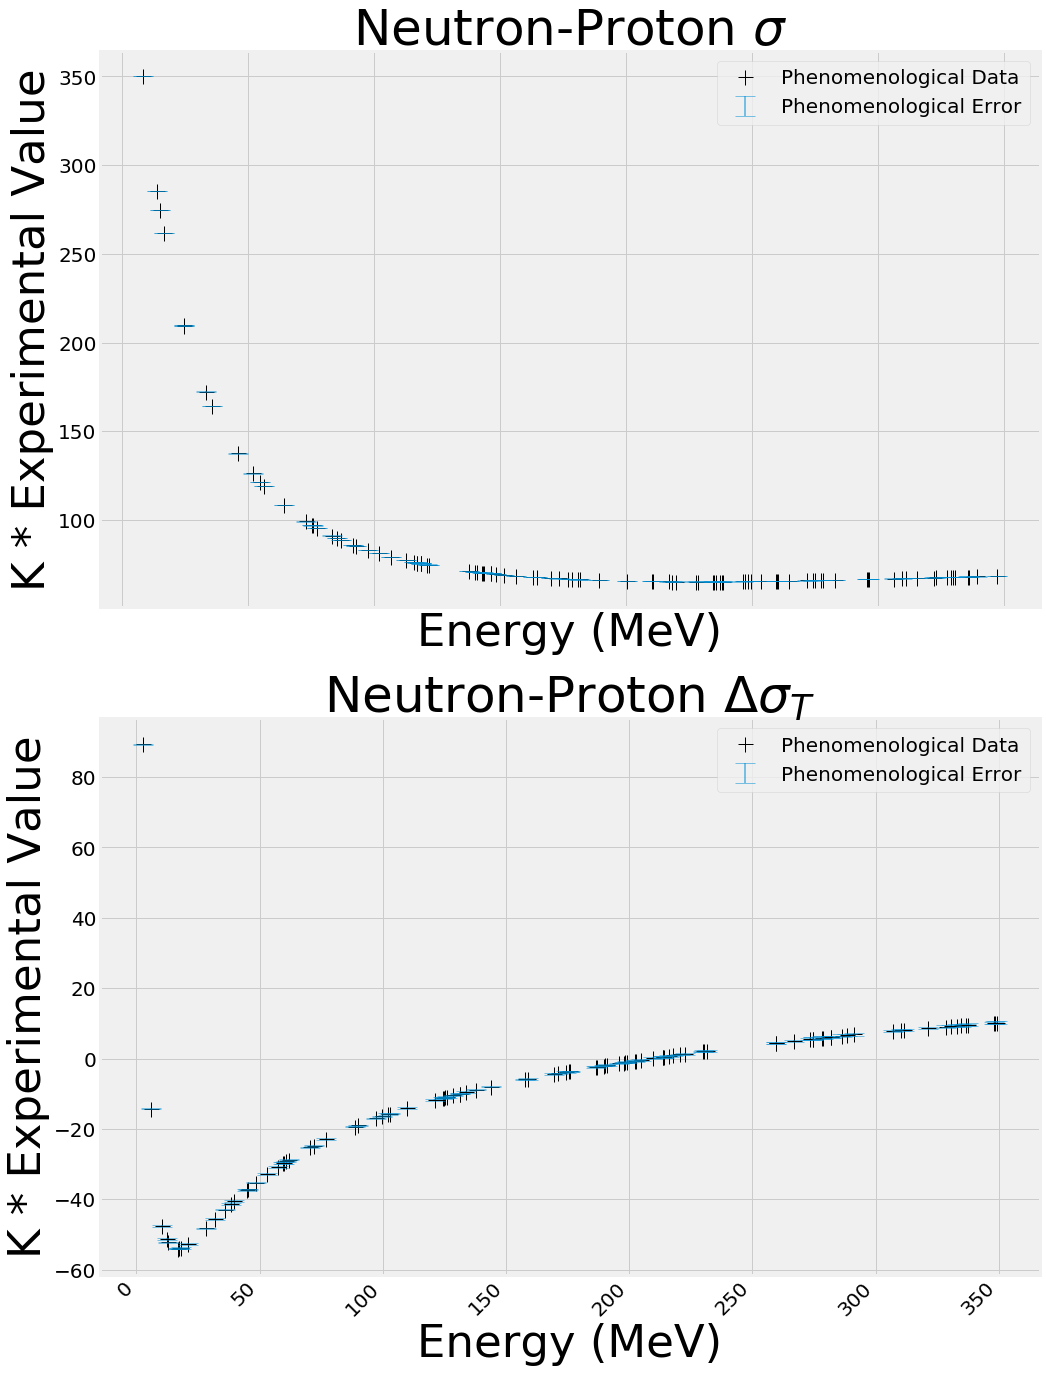

In [13]:
#One-hot encode
features = pd.get_dummies(combined_data)
# Labels are the values we want to predict
labels = np.array(features['Gauss_exp'])
# Remove the labels from the features
features = features.drop('Gauss_exp', axis = 1)
# Saving feature names for later use
feature_list = list(features.columns)
# Convert to numpy array
features = np.array(features)

train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25)

rf = RandomForestRegressor(n_estimators= 1000)
# Train the model on training data
rf.fit(train_features, train_labels);

#make predictions 
#construct testing arrays
interval_size = 1
num_intervals = 350/interval_size
E_SGT = []
E_SGTT = []
E = list(range(0, 350 + int(interval_size), interval_size))
for value in range(0, 350 + int(interval_size), interval_size):
    E_SGT.append([value, 1, 0])
    E_SGTT.append([value, 0, 1])
#predict
#SGT
SGT_predictions = rf.predict(E_SGT)
#SGTT
SGTT_predictions = rf.predict(E_SGTT)


#plot
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize = (15,25))
fig.autofmt_xdate(rotation = 45)
#plot 1
#ax1.plot(E, SGT_predictions, 'rx', markersize=15,  alpha=1.0, label='Predictions')
#ax1.plot(np_sgt['energy'], np_sgt['K_experimental_value'], 'bo', alpha=0.3, label='Raw Experimental Data')
ax1.plot(random_sgt['energy'], random_sgt['K_experimental_value'], 'k+', markersize=15, label='Phenomenological Data')
#ax1.errorbar(np_sgt['energy'], np_sgt['K_experimental_value'], yerr=exp_err_sgt, linestyle='none', capsize=10, elinewidth=2, alpha=0.5, label='Experimental Error')
ax1.errorbar(random_sgt['energy'], random_sgt['K_experimental_value'], yerr=rand_err_sgt, linestyle='none', capsize=10, elinewidth=2, alpha=0.5, label='Phenomenological Error')
ax1.tick_params(axis="y", labelsize=20); ax1.tick_params(axis="x", labelsize=20)
ax1.legend(loc='best', fontsize=20)
ax1.set_xlabel('Energy (MeV)', fontsize=45); ax1.set_ylabel('K * Experimental Value', fontsize=45); ax1.set_title('Neutron-Proton $\sigma$', fontsize=50)

#plot 2
#ax2.plot(E, SGTT_predictions, 'rx', markersize=15, alpha=1.0, label='Predictions')
#ax2.plot(np_sgtt['energy'], np_sgtt['K_experimental_value'], 'bo', alpha=0.3, label='Raw Experimental Data')
ax2.plot(random_sgtt['energy'], random_sgtt['K_experimental_value'], 'k+', markersize=15, label='Phenomenological Data')
#ax2.errorbar(np_sgtt['energy'], np_sgtt['K_experimental_value'], yerr=exp_err_sgtt, linestyle='none', capsize=10, elinewidth=2, alpha=0.5, label='Experimental Error')
ax2.errorbar(random_sgtt['energy'], random_sgtt['K_experimental_value'], yerr=rand_err_sgtt, linestyle='none', capsize=10, elinewidth=2, alpha=0.5, label='Phenomenological Error')
ax2.tick_params(axis="y", labelsize=20); ax2.tick_params(axis="x", labelsize=20)
ax2.legend(loc='best', fontsize=20)
ax2.set_xlabel('Energy (MeV)', fontsize=45); ax2.set_ylabel('K * Experimental Value', fontsize=45); ax2.set_title('Neutron-Proton $\Delta \sigma_T$', fontsize=50)
#save figures
plt.savefig('Plots/predictions_with_phenom.pdf', format='pdf', bbox_inches='tight', transparent=True)